# Demand Forecasting

This notebook consists of an exporatory data analysis and a LSTM neural network forecast modelling for Gastromatic. The objective of the problem is to forecast 14 days worth of sales data over the 32 kinds of products using a 3 year historical sales dataset.

The data consists of 3 CSV spreadsheets compressed into a zip. The data fields are:
- kind: The kind of product
- time: The hourly time this product was sold
- cancellation: A numerical boolean indicating a purchase cancellation
- guests: The number of quests
- group: The category of the product kind
- table: The table number
- article_number: The purchase ID
- ticket: The ticket ID
- invoice_closed: The time the invoice closed
- invoice_close: The time the request to close an invoice started
- invoice_opened: The time the invoice was opened

## 1. Load libraries

In [248]:
import tensorflow as tf
from zipfile import ZipFile
import urllib.request as ur
from sklearn import linear_model
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import darksky

ModuleNotFoundError: No module named 'darksky'

## 2. Load data from URL

In [2]:
CSV_DATA_ZIP_ENDPOINT = "https://www.dropbox.com/sh/0fcqy5qxqhfk8iy/AAAxSM4y_7aY03LhOmOj5Rnna?dl=1"
ur.urlretrieve(CSV_DATA_ZIP_ENDPOINT, "data.zip")

In [3]:
# Extract zip file
ZipFile("data.zip").extractall(path="data")
filepaths = list(map(lambda v:"./data/%s" % v, os.listdir("data")))
filepaths

['./data/POS_data_2018.csv',
 './data/POS_data_2017.csv',
 './data/POS_data_2016.csv',
 './data/POS_data_2015.csv']

In [4]:
# merge all files into one dataframe
dfs = list(map(lambda file: pd.read_csv(file), filepaths))
df = pd.concat(dfs)
df.time = pd.to_datetime(df.time)
df.index = df.time
df.guests = df.guests.astype("category")
df.head()

,Unnamed: 0,kind,invoice_closed,invoice_opened,guests,group,invoice,cancellation,ticket,table,time,article_number,invoice_close
time,,,,,,,,,,,,,
2017-12-31 11:52:00,0,Pasta,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Essen,3790,0,2289,101/1,2017-12-31 11:52:00,206,NaN
2017-12-31 11:52:00,1,Pasta,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Speisen,3790,0,2289,101/1,2017-12-31 11:52:00,213,NaN
2017-12-31 11:52:00,2,Limonaden,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Getränke,3790,0,2289,101/1,2017-12-31 11:52:00,56,NaN
2017-12-31 11:52:00,3,Undefiniert,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Undefiniert,3790,0,2289,101/1,2017-12-31 11:52:00,262,NaN
2017-12-31 12:18:00,4,Weisswein offen,2017-12-31 13:20:00,2017-12-31 12:18:00,5,Getränke,3794,0,2292,116/1,2017-12-31 12:18:00,334,NaN


## 3. Missing Values Detection:

In [5]:
# filter null values
df.dropna()

# filter "Undefiniert" values
nulls = df[df.kind.apply(lambda k: k == "Undefiniert")]
print("Removed %s null rows" % nulls.count(axis=0).kind)
df = df[df.kind.apply(lambda k: k != "Undefiniert")]
df.head()

Removed 46729 null rows


,Unnamed: 0,kind,invoice_closed,invoice_opened,guests,group,invoice,cancellation,ticket,table,time,article_number,invoice_close
time,,,,,,,,,,,,,
2017-12-31 11:52:00,0,Pasta,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Essen,3790,0,2289,101/1,2017-12-31 11:52:00,206,NaN
2017-12-31 11:52:00,1,Pasta,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Speisen,3790,0,2289,101/1,2017-12-31 11:52:00,213,NaN
2017-12-31 11:52:00,2,Limonaden,2017-12-31 12:21:00,2017-12-31 11:52:00,2,Getränke,3790,0,2289,101/1,2017-12-31 11:52:00,56,NaN
2017-12-31 12:18:00,4,Weisswein offen,2017-12-31 13:20:00,2017-12-31 12:18:00,5,Getränke,3794,0,2292,116/1,2017-12-31 12:18:00,334,NaN
2017-12-31 12:18:00,5,Bier,2017-12-31 13:20:00,2017-12-31 12:18:00,5,Getränke,3794,0,2292,116/1,2017-12-31 12:18:00,135,NaN


## 4. Exploratory data analysis

In [7]:
# Viewing all kind categories
kinds = pd.unique(df["kind"].to_numpy().ravel())
groups = pd.unique(df["group"].to_numpy().ravel())
print("Kinds: %s\n\nGroups: %s" % (kinds, groups))

Kinds: ['Pasta' 'Limonaden' 'Weisswein offen' 'Bier' 'Getränke' 'Antipasti'
 'Wasser' 'al forno' 'Pizza' 'Gnocci' 'Kaffee/Schoko' 'Schorlen' 'Salate'
 'Dolci' 'Specials' 'Aperitiv' 'Cocktail alkfrei' 'Extrabeilagen'
 'Suppen ' 'Säfte' 'Spirituosen' 'Cocktail' 'Eis' 'Salat'
 'Handelswaren / Divers' 'Infotexte' 'Mittagstisch' 'Rotwein offen'
 'Prosecco' 'Weisswein Flasche' 'Rotwein Flasche' 'Suppe']

Groups: ['Essen' 'Speisen' 'Getränke ' 'Getränke' 'Undefiniert' 'Handel' 'SYSTEM']


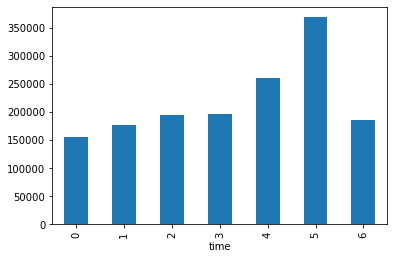

In [8]:
# Look at most demand per weekday
df.groupby(df.time.dt.dayofweek).time.count().plot(kind="bar")

> Here is seems Sundays don't bother the number of sales, but Saturdays are the most common day to buy.

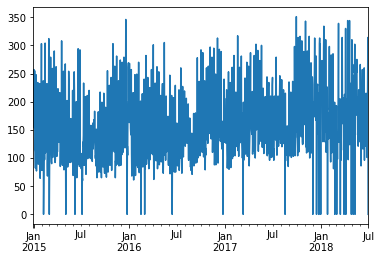

In [224]:
# Look at demand for single product over time
GRANULARITY = "D"
min_date = df.index.min()
max_date = df.index.max()
time_index = pd.date_range(
        start=min_date, end=max_date, normalize=True)

def get_kind_ts(kind, remove_outliers=True):
    single_kind = df[df.kind.apply(lambda k: k == kind)]
    single_kind = single_kind.resample(GRANULARITY).count()
    
    if remove_outliers:
        # remove outliers lower and upper quantile
        q_low = single_kind.time.quantile(0.01)
        q_hi  = single_kind.time.quantile(0.99)
        single_kind = single_kind[(single_kind.time < q_hi) & (single_kind.time > q_low)]
    
    time_spaced = pd.DataFrame(index=time_index, columns=["qty"])
    time_spaced = time_spaced.resample(GRANULARITY).count()
    
    for index, row in single_kind.iterrows():
        time_spaced.loc[index] = row.kind
    
    return time_spaced

# Augment data with periodic time data
def augment_data(data):
    return pd.DataFrame(
        data={
            "dayofweek": data.index.dayofweek,
            "dayofmonth": data.index.day,
            "week": data.index.week,
            "month": data.index.month,
            "qty": data.qty
        },
        index = data.index,
    )

sales_pasta = get_kind_ts("Pasta")
sales_pasta = augment_data(sales_pasta)
sales_pasta.qty.plot()

## 5. Normalize data

Here we use z-score normalization where the mean is 0 and the standard deviation is 1 for all values.

In [258]:
from sklearn.preprocessing import MinMaxScaler

EPSILON = 1e-6
def normalize(df):
    norm = pd.DataFrame(index=df.index)
    z_values = {}
    for key in df:
        array = df[key].values.reshape(-1, 1)
        scaler = MinMaxScaler()
        scaler.fit(array)
        z_values[key] = scaler
        norm[key] = scaler.transform(array)
    return norm, z_values

def denormalize(df, z_values):
    denorm = pd.DataFrame(index=df.index)
    for key in df:
        array = df[key].values.reshape(-1, 1)
        scaler = z_values[key]
        denorm[key] = scaler.inverse_transform(array)
    return denorm

pasta_norm, pasta_zv = normalize(pasta)
print(pasta_norm.head())
denormalize(pasta_norm, pasta_zv).head()

            dayofweek  dayofmonth  week  month       qty
time                                                    
2014-12-31   0.333333    1.000000   0.0    1.0  0.553265
2015-01-01   0.500000    0.000000   0.0    0.0  0.329897
2015-01-02   0.666667    0.033333   0.0    0.0  0.676976
2015-01-03   0.833333    0.066667   0.0    0.0  0.628866
2015-01-04   1.000000    0.100000   0.0    0.0  0.319588


,dayofweek,dayofmonth,week,month,qty
time,,,,,
2014-12-31,2.0,31.0,1.0,12.0,221.0
2015-01-01,3.0,1.0,1.0,1.0,156.0
2015-01-02,4.0,2.0,1.0,1.0,257.0
2015-01-03,5.0,3.0,1.0,1.0,243.0
2015-01-04,6.0,4.0,1.0,1.0,153.0


## 5. Create baseline model

We use linear approximation as a baseline due to its simplicity and understandability before moving towards more complex models.

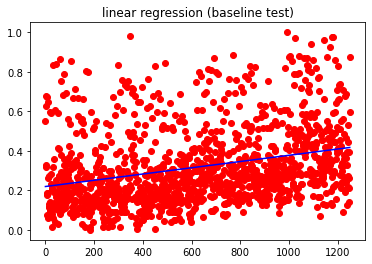

In [259]:
ys = pasta_norm.qty.values
xs = np.arange(0,ys.size,1)

xs = xs.reshape(-1, 1)
ys = ys.reshape(-1, 1)

regr = linear_model.LinearRegression()
regr.fit(xs, ys)
plt.scatter(xs, ys, color="red")
plt.plot(xs, regr.predict(xs), color="blue")
plt.title("linear regression (baseline test)")
plt.show()

In [260]:
# Our baseline that we will improve on
mse = tf.divide(tf.keras.backend.sum(tf.sqrt(tf.keras.backend.sum(tf.square(xs - regr.predict(xs))))), len(xs))
"Linear regression (baseline) mse error: %s" % mse.numpy()

'Linear regression (baseline) mse error: 20.399735581872637'

## 7. Create LSTM model

The Long Short Term Memory (LSTM) neural network model is trained over windowed timeseries in order to generate a sequence. The input data is not shuffled because the windowed data needs to be ordered and for the validation results to account for the newly timed data outside of the training scope. The model capacity is increased with stacked LSTM with dropout pattern yielding a better accuracy. To improve training speed, the number of epochs are reduced and the learning rate is increased.

Model: "functional_153"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_89 (InputLayer)        [(None, 104, 5)]          0         
_________________________________________________________________
lstm_105 (LSTM)              (None, 64)                17920     
_________________________________________________________________
dense_76 (Dense)             (None, 14)                910       
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
46/46 [==============================] - 3s 64ms/step - loss: 0.0346 - val_loss: 0.0511
Epoch 2/3
46/46 [==============================] - 3s 55ms/step - loss: 0.0280 - val_loss: 0.0313
Epoch 3/3
46/46 [==============================] - 2s 54ms/step - loss: 0.0259 - val_loss: 0.0317


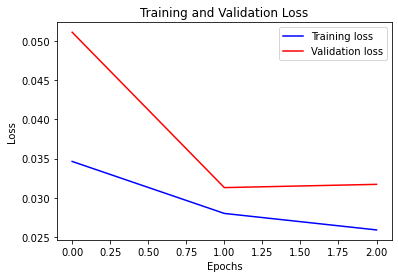

In [265]:
# Configurable hyperparameters
LOOK_BACK = 104
LOOK_AHEAD = 14
BATCH_SIZE = 14
EPOCHS = 3
LSTM_UNITS = 64
LEARNING_RATE = 0.01
DROPOUT_RATE = 0.01

INITIAL_CHPT_PATH = "initial_ckpt"
feature_len = len(pasta.values[0])

# Create LSTM model
inputs = tf.keras.layers.Input(shape=(LOOK_BACK, feature_len))
lstm_out1 = tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=False, dropout=DROPOUT_RATE)(inputs)
#lstm_out2 = tf.keras.layers.LSTM(LSTM_UNITS, dropout=DROPOUT_RATE)(lstm_out1)
outputs = tf.keras.layers.Dense(units=LOOK_AHEAD, activation="linear")(lstm_out1)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss="mse")
model.summary()

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
)

# Save initial weights to reset after training new products
model.save_weights(INITIAL_CHPT_PATH)

def split_window(features):
    total_window_size = LOOK_BACK + LOOK_AHEAD
    input_slice = slice(0, LOOK_BACK)
    label_start = total_window_size - LOOK_AHEAD
    labels_slice = slice(label_start, None)
    
    inputs = features[:, input_slice, :]
    labels = features[:, labels_slice, 4]

    return inputs, labels

def create_dataset(data, shuffle=False):
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=LOOK_BACK+LOOK_AHEAD,
        batch_size=BATCH_SIZE,
        shuffle=shuffle
    )
    dataset = dataset.map(split_window)
    
    return dataset

def split_and_train(dataset, name="unnamed"):
    # split 60% train, 30% batch, 10% test
    split_train_val = int(len(dataset) * 0.6)
    split_val_test = int(len(dataset) * 0.9)

    train_data = dataset[:split_train_val]
    val_data = dataset[split_train_val:split_val_test]
    test_data = dataset[split_val_test:]

    train_batched = create_dataset(train_data, shuffle=False)
    val_batched = create_dataset(val_data)
    
    # reset model weights
    model.load_weights(INITIAL_CHPT_PATH)
    
    model_ckpt = modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
        monitor="val_loss",
        filepath=name,
        save_weights_only=True,
        save_best_only=True,
    ) 
    
    history = model.fit(
        train_batched,
        epochs=EPOCHS,
        validation_data=val_batched,
        callbacks=[es_callback, model_ckpt]
    )
    return history, test_data

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


history, pasta_test_norm = split_and_train(pasta_norm, "test-pasta")

visualize_loss(history, "Training and Validation Loss")

## 8. Forecast with test data

            qty
2018-06-30  185
2018-07-01  149
2018-07-02  118
2018-07-03  114
2018-07-04  159
2018-07-05  219
2018-07-06  225
2018-07-07  168
2018-07-08  127
2018-07-09  134
2018-07-10  108
2018-07-11  152
2018-07-12  197
2018-07-13  220
Sum of predicted sales 14 days ahead: 2279


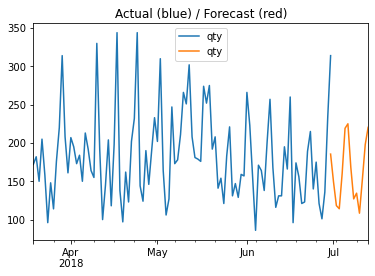

In [266]:
def forecast_model(test_data, z_values, model_ckpt_path, title="Actual (blue) / Forecast (red)"):
    model.load_weights(model_ckpt_path)
    input = test_data[-LOOK_BACK:]
    last_date = test_data.index.max()
    actual = pd.DataFrame(
        data=input.qty.values,
        columns=["qty"],
        index=pd.date_range(end=last_date, periods=LOOK_BACK, normalize=True)
    )
    pred = pd.DataFrame(
        data=model.predict(input.values.reshape(1, LOOK_BACK, feature_len))[0],
        columns=["qty"],
        index=pd.date_range(start=last_date, periods=LOOK_AHEAD, normalize=True)
    )

    actual = denormalize(actual, z_values)
    pred = denormalize(pred, z_values)
    print(pred.astype(int))

    ax = actual.plot(label="Actual", title=title)
    pred.plot(ax = ax, label="Forecast")

    print("Sum of predicted sales %s days ahead: %s" % (LOOK_AHEAD, int(pred.sum())))
    
forecast_model(pasta_test_norm, pasta_zv, "test-pasta")

## 9. Batch training over all products

Training for kind: Pasta
Epoch 1/3
47/47 [==============================] - 3s 61ms/step - loss: 0.0342 - val_loss: 0.0416
Epoch 2/3
47/47 [==============================] - 3s 58ms/step - loss: 0.0231 - val_loss: 0.0318
Epoch 3/3
47/47 [==============================] - 3s 56ms/step - loss: 0.0200 - val_loss: 0.0311


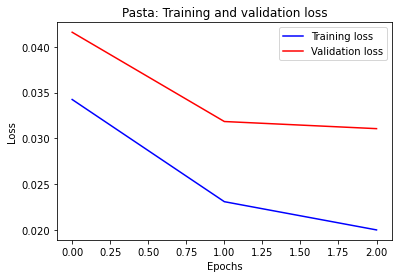

Training for kind: Limonaden
Epoch 1/3
47/47 [==============================] - 3s 54ms/step - loss: 0.0434 - val_loss: 0.0366
Epoch 2/3
47/47 [==============================] - 2s 53ms/step - loss: 0.0301 - val_loss: 0.0314
Epoch 3/3
47/47 [==============================] - 3s 53ms/step - loss: 0.0245 - val_loss: 0.0306


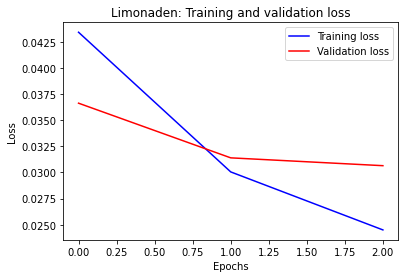

Training for kind: Weisswein offen
Epoch 1/3
47/47 [==============================] - 2s 53ms/step - loss: 0.0470 - val_loss: 0.0474
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0322 - val_loss: 0.0454
Epoch 3/3
47/47 [==============================] - 3s 53ms/step - loss: 0.0297 - val_loss: 0.0435


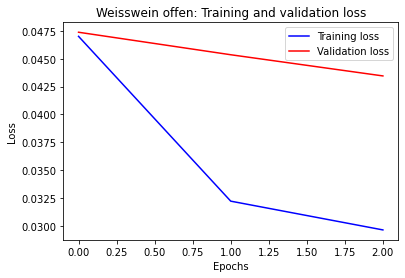

Training for kind: Bier
Epoch 1/3
47/47 [==============================] - 3s 54ms/step - loss: 0.0409 - val_loss: 0.0314
Epoch 2/3
47/47 [==============================] - 3s 53ms/step - loss: 0.0265 - val_loss: 0.0314
Epoch 3/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0245 - val_loss: 0.0322


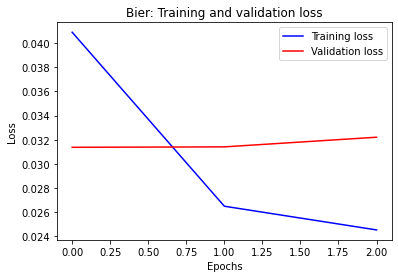

Training for kind: Getränke
Epoch 1/3
47/47 [==============================] - 3s 54ms/step - loss: 0.0013 - val_loss: 0.1297
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 4.4359e-04 - val_loss: 0.1297
Epoch 3/3
47/47 [==============================] - 3s 53ms/step - loss: 3.5408e-04 - val_loss: 0.1285


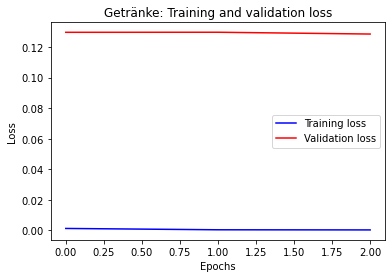

Training for kind: Antipasti
Epoch 1/3
47/47 [==============================] - 3s 54ms/step - loss: 0.0517 - val_loss: 0.0357
Epoch 2/3
47/47 [==============================] - 3s 54ms/step - loss: 0.0374 - val_loss: 0.0300
Epoch 3/3
47/47 [==============================] - 2s 53ms/step - loss: 0.0318 - val_loss: 0.0251


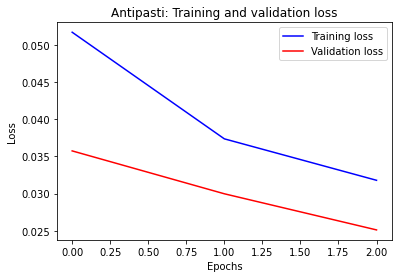

Training for kind: Wasser
Epoch 1/3
47/47 [==============================] - 2s 53ms/step - loss: 0.0355 - val_loss: 0.0348
Epoch 2/3
47/47 [==============================] - 3s 53ms/step - loss: 0.0226 - val_loss: 0.0331
Epoch 3/3
47/47 [==============================] - 3s 54ms/step - loss: 0.0205 - val_loss: 0.0306


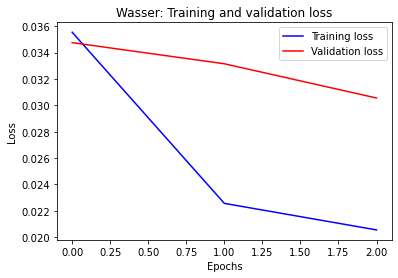

Training for kind: al forno
Epoch 1/3
47/47 [==============================] - 2s 53ms/step - loss: 0.0465 - val_loss: 0.0439
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0374 - val_loss: 0.0355
Epoch 3/3
47/47 [==============================] - 3s 54ms/step - loss: 0.0341 - val_loss: 0.0314


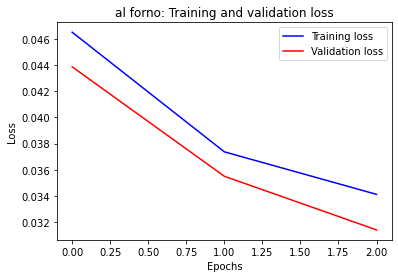

Training for kind: Pizza
Epoch 1/3
47/47 [==============================] - 3s 53ms/step - loss: 0.0412 - val_loss: 0.0361
Epoch 2/3
47/47 [==============================] - 3s 53ms/step - loss: 0.0325 - val_loss: 0.0331
Epoch 3/3
47/47 [==============================] - 3s 53ms/step - loss: 0.0275 - val_loss: 0.0287


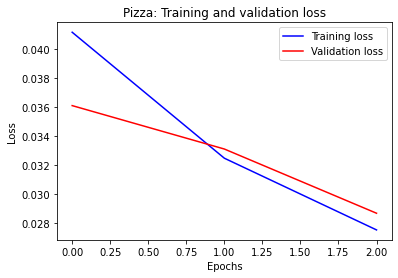

Training for kind: Gnocci
Epoch 1/3
47/47 [==============================] - 3s 54ms/step - loss: 0.0333 - val_loss: 0.0397
Epoch 2/3
47/47 [==============================] - 2s 53ms/step - loss: 0.0267 - val_loss: 0.0423
Epoch 3/3
47/47 [==============================] - 3s 53ms/step - loss: 0.0269 - val_loss: 0.0354


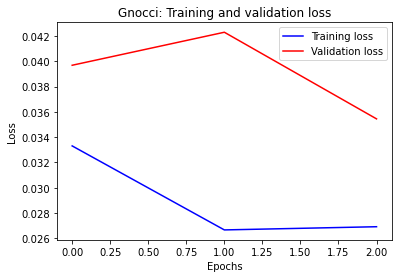

Training for kind: Kaffee/Schoko
Epoch 1/3
47/47 [==============================] - 3s 54ms/step - loss: 0.0401 - val_loss: 0.0392
Epoch 2/3
47/47 [==============================] - 3s 54ms/step - loss: 0.0359 - val_loss: 0.0401
Epoch 3/3
47/47 [==============================] - 3s 54ms/step - loss: 0.0387 - val_loss: 0.0346


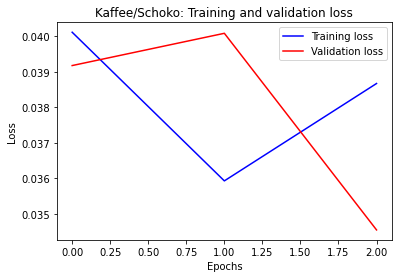

Training for kind: Schorlen
Epoch 1/3
47/47 [==============================] - 2s 53ms/step - loss: 0.0418 - val_loss: 0.0365
Epoch 2/3
47/47 [==============================] - 3s 55ms/step - loss: 0.0330 - val_loss: 0.0314
Epoch 3/3
47/47 [==============================] - 3s 53ms/step - loss: 0.0316 - val_loss: 0.0273


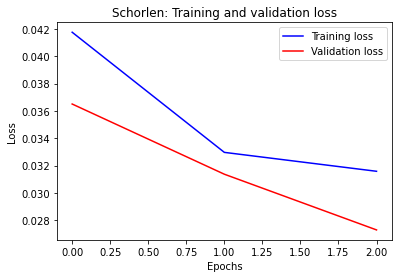

Training for kind: Salate
Epoch 1/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0433 - val_loss: 0.0318
Epoch 2/3
47/47 [==============================] - 2s 53ms/step - loss: 0.0315 - val_loss: 0.0283
Epoch 3/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0270 - val_loss: 0.0253


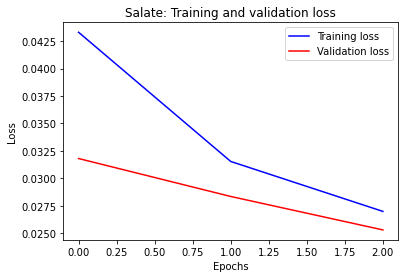

Training for kind: Dolci
Epoch 1/3
47/47 [==============================] - 3s 54ms/step - loss: 0.0426 - val_loss: 0.0631
Epoch 2/3
47/47 [==============================] - 3s 54ms/step - loss: 0.0429 - val_loss: 0.0582
Epoch 3/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0423 - val_loss: 0.0360


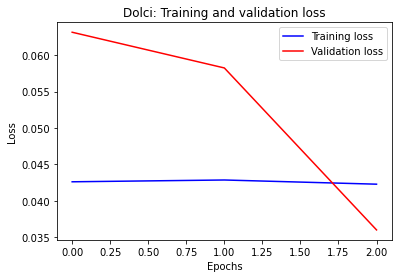

Training for kind: Specials
Epoch 1/3
47/47 [==============================] - 2s 53ms/step - loss: 0.0389 - val_loss: 0.1285
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0543 - val_loss: 0.0178
Epoch 3/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0428 - val_loss: 0.0179


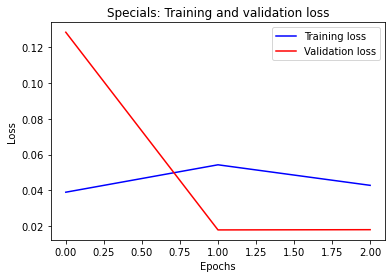

Training for kind: Aperitiv
Epoch 1/3
47/47 [==============================] - 2s 53ms/step - loss: 0.0471 - val_loss: 0.0470
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0381 - val_loss: 0.0391
Epoch 3/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0352 - val_loss: 0.0330


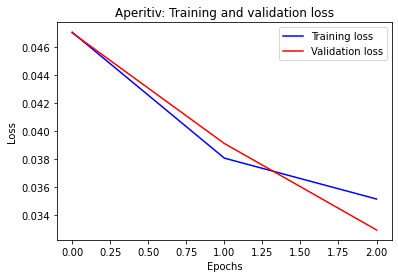

Training for kind: Cocktail alkfrei
Epoch 1/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0095 - val_loss: 0.0846
Epoch 2/3
47/47 [==============================] - 2s 53ms/step - loss: 0.0115 - val_loss: 0.0530
Epoch 3/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0118 - val_loss: 0.0710


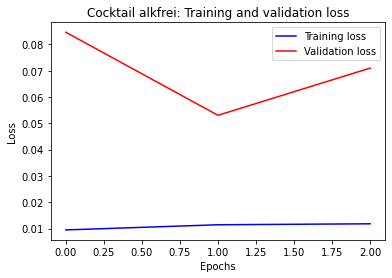

Training for kind: Extrabeilagen
Epoch 1/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0134 - val_loss: 0.0903
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0138 - val_loss: 0.0997
Epoch 3/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0134 - val_loss: 0.1037


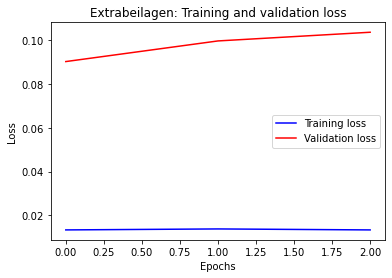

Training for kind: Suppen 
Epoch 1/3
47/47 [==============================] - 2s 49ms/step - loss: 0.0581 - val_loss: 0.1091
Epoch 2/3
47/47 [==============================] - 2s 50ms/step - loss: 0.0640 - val_loss: 0.0290
Epoch 3/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0506 - val_loss: 0.0286


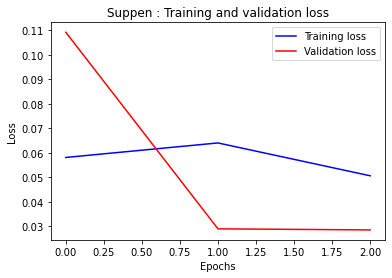

Training for kind: Säfte
Epoch 1/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0549 - val_loss: 0.0329
Epoch 2/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0425 - val_loss: 0.0352
Epoch 3/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0387 - val_loss: 0.0359


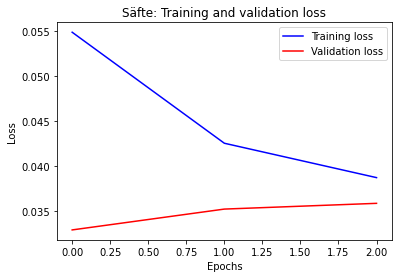

Training for kind: Spirituosen
Epoch 1/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0458 - val_loss: 0.0528
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0453 - val_loss: 0.0432
Epoch 3/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0441 - val_loss: 0.0412


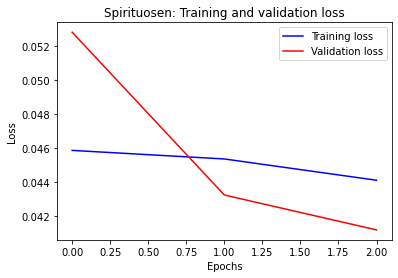

Training for kind: Cocktail
Epoch 1/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0197 - val_loss: 0.0376
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0199 - val_loss: 0.0435
Epoch 3/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0193 - val_loss: 0.0482


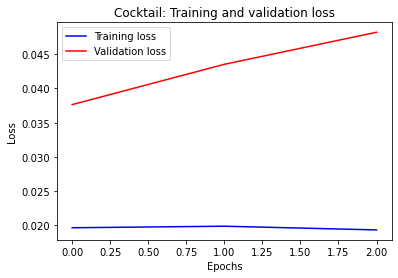

Training for kind: Eis
Epoch 1/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0441 - val_loss: 0.0479
Epoch 2/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0471 - val_loss: 0.0473
Epoch 3/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0478 - val_loss: 0.0436


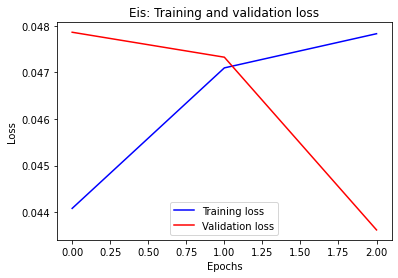

Training for kind: Salat
Epoch 1/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0204 - val_loss: 0.0578
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0203 - val_loss: 0.0649
Epoch 3/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0240 - val_loss: 0.0672


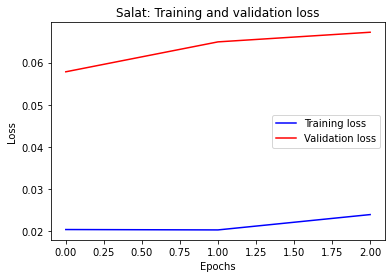

Training for kind: Handelswaren / Divers
Epoch 1/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0308 - val_loss: 5.9417e-04
Epoch 2/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0299 - val_loss: 4.6853e-04
Epoch 3/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0302 - val_loss: 3.2244e-04


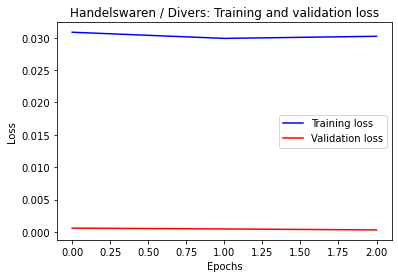

Training for kind: Infotexte
Epoch 1/3
47/47 [==============================] - 2s 52ms/step - loss: 9.8242e-04 - val_loss: 3.9800e-04
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 1.2069e-04 - val_loss: 4.9617e-05
Epoch 3/3
47/47 [==============================] - 2s 51ms/step - loss: 3.9326e-05 - val_loss: 2.4626e-05


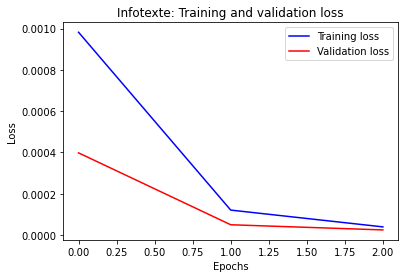

Training for kind: Mittagstisch
Epoch 1/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0267 - val_loss: 0.0011
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0294 - val_loss: 7.7606e-04
Epoch 3/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0318 - val_loss: 0.0010


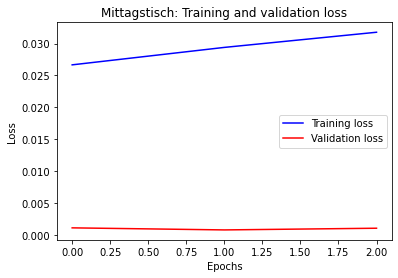

Training for kind: Rotwein offen
Epoch 1/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0414 - val_loss: 0.2072
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0468 - val_loss: 0.1806
Epoch 3/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0636 - val_loss: 0.0623


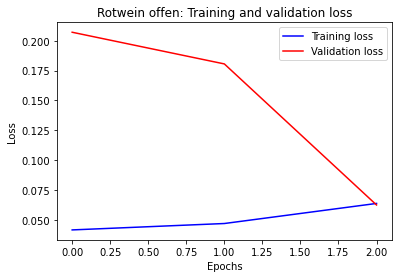

Training for kind: Prosecco
Epoch 1/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0323 - val_loss: 0.0222
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0339 - val_loss: 0.0208
Epoch 3/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0352 - val_loss: 0.0170


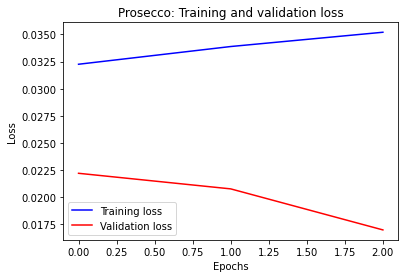

Training for kind: Weisswein Flasche
Epoch 1/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0404 - val_loss: 0.0341
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0372 - val_loss: 0.0353
Epoch 3/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0362 - val_loss: 0.0325


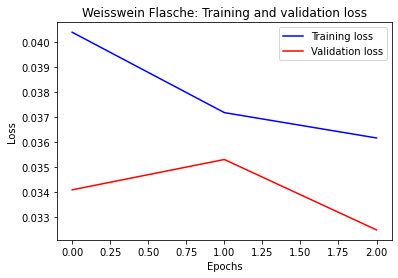

Training for kind: Rotwein Flasche
Epoch 1/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0539 - val_loss: 0.0405
Epoch 2/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0522 - val_loss: 0.0460
Epoch 3/3
47/47 [==============================] - 2s 50ms/step - loss: 0.0547 - val_loss: 0.0322


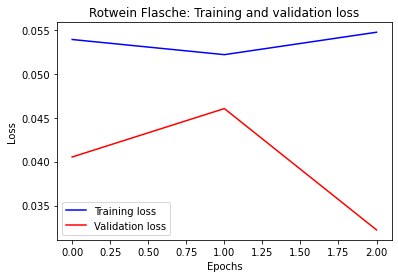

Training for kind: Suppe
Epoch 1/3
47/47 [==============================] - 2s 53ms/step - loss: 0.0080 - val_loss: 1.6956e-04
Epoch 2/3
47/47 [==============================] - 2s 52ms/step - loss: 0.0078 - val_loss: 2.1339e-04
Epoch 3/3
47/47 [==============================] - 2s 51ms/step - loss: 0.0079 - val_loss: 4.0430e-04


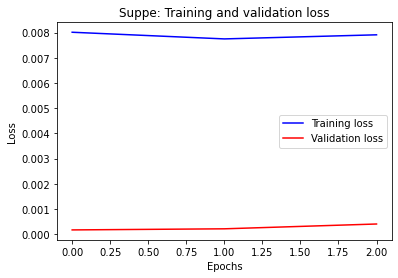

In [267]:
zv_kinds = {}
test_data_kinds = {}

for idx, kind in enumerate(kinds):
    print("Training for kind: %s" % kind)
    kind_sales = get_kind_ts(kind)
    kind_sales = augment_data(kind_sales)
    norm_kind, zv_kind = normalize(kind_sales)
    history_kind, test_data_kind = split_and_train(norm_kind, "model-%s" % idx)
    visualize_loss(history_kind, "%s: Training and validation loss" % kind)
    zv_kinds[kind] = zv_kind
    test_data_kinds[kind] = test_data_kind

## 10. Forecast all products

Forecast for: Pasta
            qty
2018-07-01  134
2018-07-02  115
2018-07-03  126
2018-07-04  157
2018-07-05  186
2018-07-06  217
2018-07-07  167
2018-07-08  144
2018-07-09  132
2018-07-10  128
2018-07-11  146
2018-07-12  191
2018-07-13  207
2018-07-14  179
Sum of predicted sales 14 days ahead: 2235
Forecast for: Limonaden
            qty
2018-07-01   93
2018-07-02   78
2018-07-03   80
2018-07-04  107
2018-07-05  135
2018-07-06  155
2018-07-07  118
2018-07-08   82
2018-07-09   71
2018-07-10   69
2018-07-11   95
2018-07-12  133
2018-07-13  151
2018-07-14  133
Sum of predicted sales 14 days ahead: 1508
Forecast for: Weisswein offen
            qty
2018-07-01   42
2018-07-02   47
2018-07-03   53
2018-07-04   49
2018-07-05   59
2018-07-06   63
2018-07-07   44
2018-07-08   46
2018-07-09   47
2018-07-10   44
2018-07-11   47
2018-07-12   68
2018-07-13   66
2018-07-14   47
Sum of predicted sales 14 days ahead: 729
Forecast for: Bier
            qty
2018-07-01  103
2018-07-02  105
2018-07-03 

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


            qty
2018-07-01    6
2018-07-02    5
2018-07-03    5
2018-07-04    5
2018-07-05    6
2018-07-06    7
2018-07-07    7
2018-07-08    6
2018-07-09    4
2018-07-10    4
2018-07-11    4
2018-07-12    5
2018-07-13    6
2018-07-14    8
Sum of predicted sales 14 days ahead: 84
Forecast for: Salat
            qty
2018-07-01    0
2018-07-02    0
2018-07-03    0
2018-07-04    0
2018-07-05    0
2018-07-06    0
2018-07-07    0
2018-07-08    0
2018-07-09    0
2018-07-10    0
2018-07-11    0
2018-07-12    0
2018-07-13    1
2018-07-14    0
Sum of predicted sales 14 days ahead: 6
Forecast for: Handelswaren / Divers


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


            qty
2018-07-01    0
2018-07-02    0
2018-07-03    0
2018-07-04    0
2018-07-05    0
2018-07-06    0
2018-07-07    0
2018-07-08    0
2018-07-09    0
2018-07-10    0
2018-07-11    0
2018-07-12    0
2018-07-13    0
2018-07-14    0
Sum of predicted sales 14 days ahead: 0
Forecast for: Infotexte
            qty
2018-07-01    0
2018-07-02    0
2018-07-03    0
2018-07-04    0
2018-07-05    0
2018-07-06    0
2018-07-07    0
2018-07-08    0
2018-07-09    0
2018-07-10    0
2018-07-11    0
2018-07-12    0
2018-07-13    0
2018-07-14    0
Sum of predicted sales 14 days ahead: 0
Forecast for: Mittagstisch


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


            qty
2018-07-01   -2
2018-07-02    0
2018-07-03    1
2018-07-04    0
2018-07-05    0
2018-07-06   -2
2018-07-07   -2
2018-07-08    0
2018-07-09    0
2018-07-10    0
2018-07-11    0
2018-07-12    0
2018-07-13   -1
2018-07-14   -1
Sum of predicted sales 14 days ahead: -8
Forecast for: Rotwein offen
            qty
2018-07-01   19
2018-07-02   20
2018-07-03   20
2018-07-04   22
2018-07-05   22
2018-07-06   26
2018-07-07   22
2018-07-08   21
2018-07-09   21
2018-07-10   20
2018-07-11   22
2018-07-12   24
2018-07-13   26
2018-07-14   23


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Sum of predicted sales 14 days ahead: 315
Forecast for: Prosecco
            qty
2018-07-01    2
2018-07-02    1
2018-07-03    3
2018-07-04    5
2018-07-05    8
2018-07-06    8
2018-07-07    5
2018-07-08    3
2018-07-09    2
2018-07-10    4
2018-07-11    5
2018-07-12    7
2018-07-13    7
2018-07-14    6
Sum of predicted sales 14 days ahead: 72
Forecast for: Weisswein Flasche


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


            qty
2018-07-01    1
2018-07-02    0
2018-07-03    1
2018-07-04    1
2018-07-05    2
2018-07-06    2
2018-07-07    1
2018-07-08    0
2018-07-09    0
2018-07-10    0
2018-07-11    1
2018-07-12    2
2018-07-13    2
2018-07-14    1
Sum of predicted sales 14 days ahead: 22
Forecast for: Rotwein Flasche
            qty
2018-07-01    0
2018-07-02    0
2018-07-03    0
2018-07-04    1
2018-07-05    2
2018-07-06    2
2018-07-07    1
2018-07-08    0
2018-07-09    0
2018-07-10    0
2018-07-11    1
2018-07-12    2
2018-07-13    1
2018-07-14    1
Sum of predicted sales 14 days ahead: 19
Forecast for: Suppe


/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


            qty
2018-07-01    0
2018-07-02    0
2018-07-03    0
2018-07-04    0
2018-07-05    0
2018-07-06    0
2018-07-07    0
2018-07-08    0
2018-07-09    0
2018-07-10    0
2018-07-11    0
2018-07-12    0
2018-07-13    0
2018-07-14    0
Sum of predicted sales 14 days ahead: 0


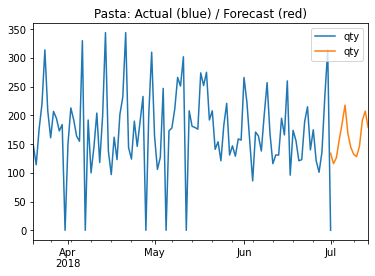

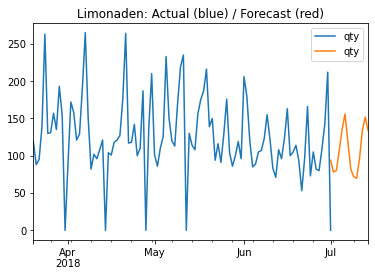

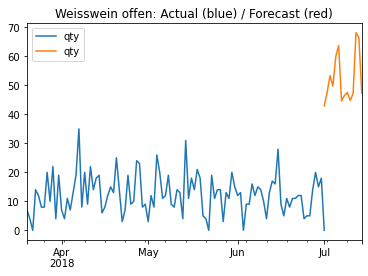

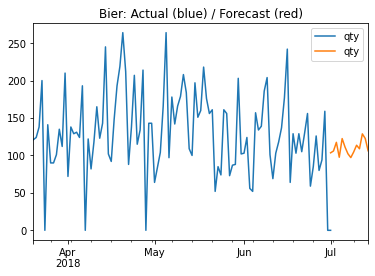

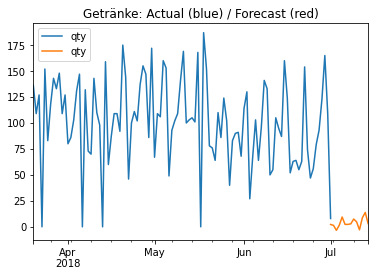

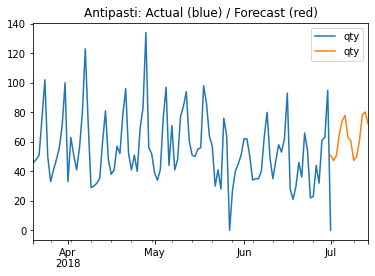

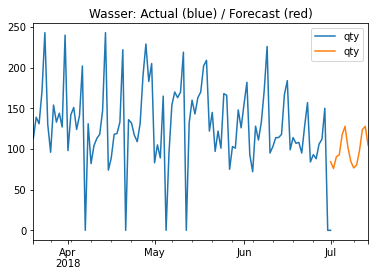

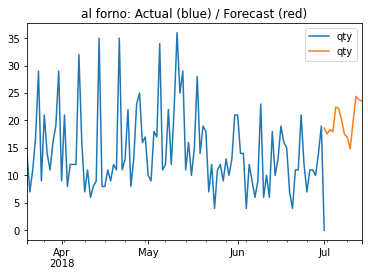

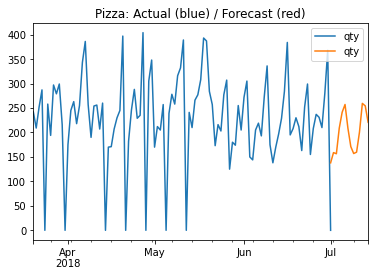

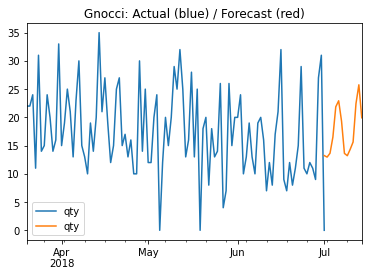

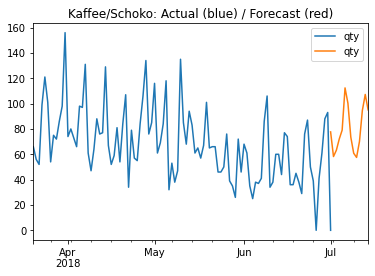

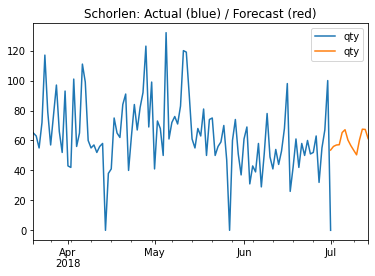

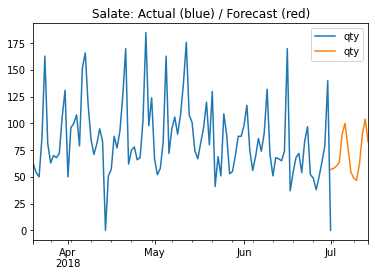

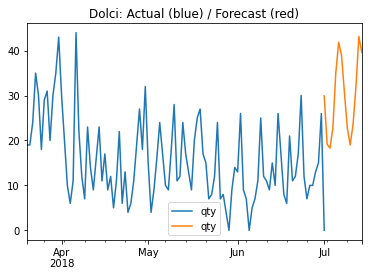

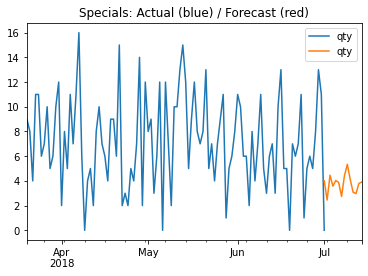

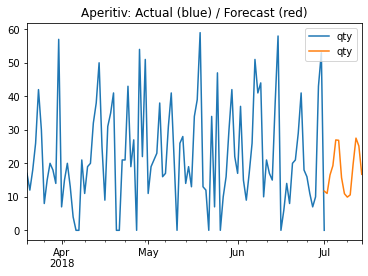

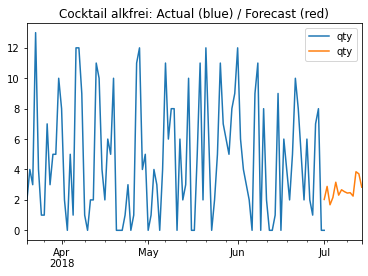

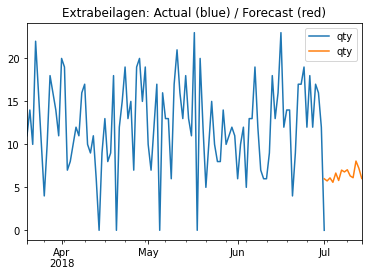

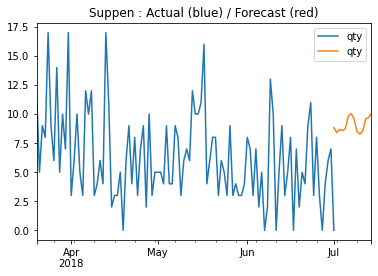

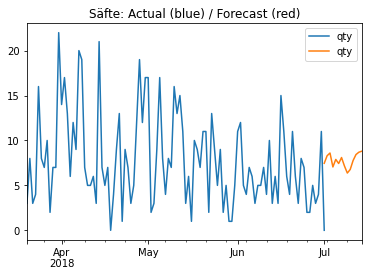

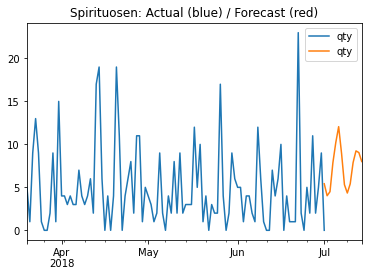

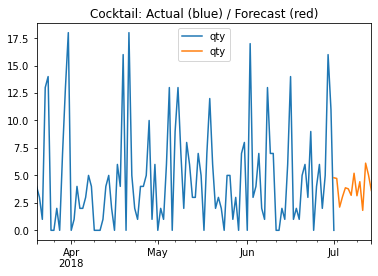

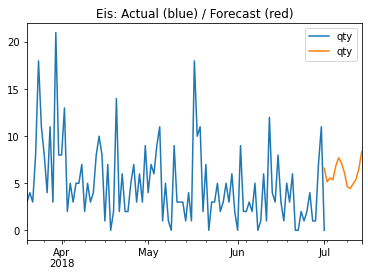

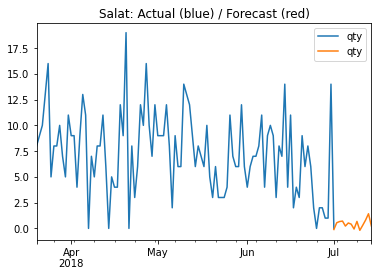

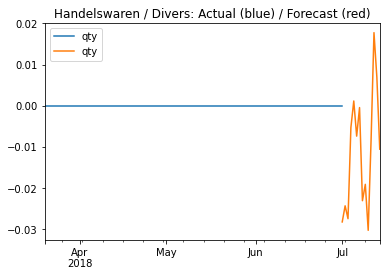

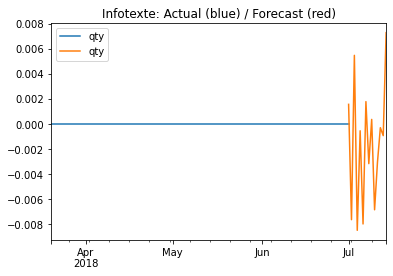

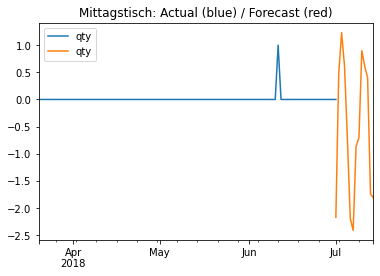

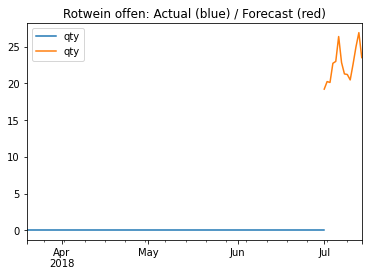

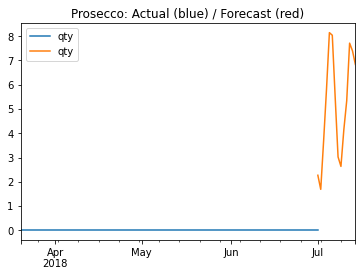

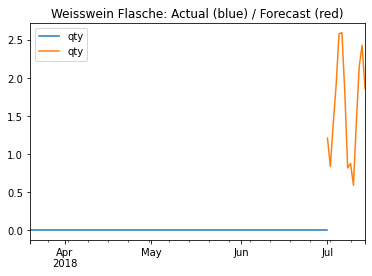

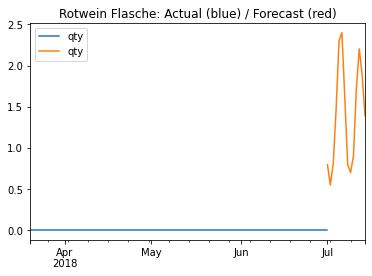

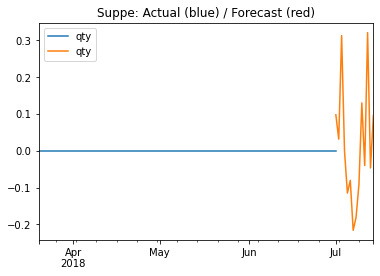

In [268]:
for idx, kind in enumerate(kinds):
    if kind in test_data_kinds:
        print("Forecast for: %s" % kind)
        test_data = test_data_kinds[kind]
        zv_kind = zv_kinds[kind]
        forecast_model(test_data, zv_kind, "model-%s" % idx, "%s: Actual (blue) / Forecast (red)" % kind)